In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# 0) Imports & config
import os, zipfile, glob, json, itertools, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

tf.get_logger().setLevel('ERROR')
SEED   = 42
IMG_SZ = 224
BATCH  = 32
EPOCHS_STAGE1 = 12
EPOCHS_STAGE2 = 12
VAL_SPLIT = 0.15
USE_MIXED_PRECISION = True
UNFREEZE_LAST = 200  # for fine-tuning

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [4]:
# 1) Locate your dataset directory (no ZIP expected)
# Looks for ".../Brain_dataset" anywhere under /kaggle/input
base_candidates = glob.glob("/kaggle/input/**/Brain_dataset", recursive=True)
assert base_candidates, "Couldn't find 'Brain_dataset' under /kaggle/input. Check dataset mount."
base_dir = base_candidates[0]
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")
assert os.path.isdir(train_dir) and os.path.isdir(test_dir), \
    f"Expected train/test in {base_dir}. Found train={os.path.isdir(train_dir)} test={os.path.isdir(test_dir)}"

print("Base dir:", base_dir)
print("Train classes:", [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir,d))])
print("Test  classes:", [d for d in os.listdir(test_dir)  if os.path.isdir(os.path.join(test_dir,d))])

Base dir: /kaggle/input/brain-image/Brain_dataset
Train classes: ['No Impairment', 'Very Mild Impairment', 'Moderate Impairment', 'Mild Impairment']
Test  classes: ['No Impairment', 'Very Mild Impairment', 'Moderate Impairment', 'Mild Impairment']


In [5]:
# 2) tf.data pipelines
common_kwargs = dict(
    image_size=(IMG_SZ, IMG_SZ),
    batch_size=BATCH,
    seed=SEED,
    color_mode="rgb"   # keep 3-channel for pretrained backbones
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=VAL_SPLIT, subset="training", **common_kwargs
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=VAL_SPLIT, subset="validation", **common_kwargs
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, shuffle=False, **common_kwargs
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Save label map
with open("/kaggle/working/labels.json", "w") as f:
    json.dump({i:c for i,c in enumerate(class_names)}, f, indent=2)

# Performance: cache/prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1024, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Optional: Mixed precision
if USE_MIXED_PRECISION:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled.")
    except Exception as e:
        print("Mixed precision not enabled:", e)

Found 8663 files belonging to 4 classes.
Using 7364 files for training.


I0000 00:00:1761633922.126166      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761633922.126860      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 8663 files belonging to 4 classes.
Using 1299 files for validation.
Found 1103 files belonging to 4 classes.
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Mixed precision enabled.


In [6]:
# 3) (Optional) class weights to mitigate imbalance
def compute_class_weights(dataset, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)
    for _, y in dataset:
        y = y.numpy()
        for k in range(n_classes):
            counts[k] += np.sum(y == k)
    total = counts.sum()
    weights = {i: float(total/(n_classes*counts[i])) for i in range(n_classes) if counts[i] > 0}
    return weights, counts

class_weights, counts = compute_class_weights(
    tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, validation_split=VAL_SPLIT, subset="training", **common_kwargs
    ), num_classes
)
print("Train counts:", counts.tolist())
print("Class weights:", class_weights)

Found 8663 files belonging to 4 classes.
Using 7364 files for training.
Train counts: [1811, 1876, 1872, 1805]
Class weights: {0: 1.0165654334621756, 1: 0.9813432835820896, 2: 0.9834401709401709, 3: 1.01994459833795}


In [12]:
# 4) Augmentation (tuned)
# =========================
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.06),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.12),
    tf.keras.layers.RandomTranslation(0.04, 0.04),
], name="augment")

In [13]:
# 5) Model: EfficientNetV2B0 @ 300
# =========================
from tensorflow.keras.applications import efficientnet_v2
IMG_SZ = 300  # upgrade input size
common_kwargs.update(image_size=(IMG_SZ, IMG_SZ))

# recreate datasets at the new size
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=VAL_SPLIT, subset="training", **common_kwargs
).shuffle(1024, seed=SEED).prefetch(tf.data.AUTOTUNE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=VAL_SPLIT, subset="validation", **common_kwargs
).prefetch(tf.data.AUTOTUNE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, shuffle=False, **common_kwargs
).prefetch(tf.data.AUTOTUNE)

inp = tf.keras.Input(shape=(IMG_SZ, IMG_SZ, 3))
x = augment(inp)
x = tf.keras.layers.Lambda(efficientnet_v2.preprocess_input, name="preproc")(x)

# try pretrained, else scratch
try:
    base = efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=x)
    print("Loaded EfficientNetV2B0 with ImageNet weights.")
except Exception as e:
    print("Imagenet weights unavailable; training backbone from scratch:", e)
    base = efficientnet_v2.EfficientNetV2B0(include_top=False, weights=None, input_tensor=x)

base.trainable = False  # stage-1: freeze

x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.Dropout(0.35)(x)
dtype_out = "float32" if USE_MIXED_PRECISION else None
out = tf.keras.layers.Dense(num_classes, activation="softmax", dtype=dtype_out)(x)

model = tf.keras.Model(inp, out)
model.summary()

Found 8663 files belonging to 4 classes.
Using 7364 files for training.
Found 8663 files belonging to 4 classes.
Using 1299 files for validation.
Found 1103 files belonging to 4 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded EfficientNetV2B0 with ImageNet weights.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 300, 300,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 300, 300,  │          0 │ cast_2[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc (Lambda)    │ (None, 300, 300,  │          0 │ augment[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ preproc[0][0]     │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 75, 75,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 75, 75,    │        128 │ block2a_project_

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [14]:
# 6) Optimizer + loss
# =========================
# label smoothing + optional focal loss fallback
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

try:
    import tensorflow_addons as tfa
    # Uncomment to try focal loss instead of label smoothing:
    # loss_fn = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
    OPT = tfa.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)
except Exception:
    OPT = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(optimizer=OPT, loss=loss_fn, metrics=["accuracy"])

ckpt_stage1 = "/kaggle/working/effv2b0_stage1.keras"
cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_stage1, monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
]

# Convert integer labels to one-hot for categorical loss
def to_onehot(ds, n):
    return ds.map(lambda x, y: (x, tf.one_hot(y, n)), num_parallel_calls=tf.data.AUTOTUNE)

train_oh = to_onehot(train_ds, num_classes)
val_oh   = to_onehot(val_ds,   num_classes)

hist1 = model.fit(train_oh, validation_data=val_oh, epochs=15, callbacks=cbs, class_weight=class_weights)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3109 - loss: 1.3895
Epoch 1: val_accuracy improved from -inf to 0.57891, saving model to /kaggle/working/effv2b0_stage1.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 119ms/step - accuracy: 0.3112 - loss: 1.3891 - val_accuracy: 0.5789 - val_loss: 1.1209
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5339 - loss: 1.1080
Epoch 2: val_accuracy improved from 0.57891 to 0.62818, saving model to /kaggle/working/effv2b0_stage1.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.5341 - loss: 1.1079 - val_accuracy: 0.6282 - val_loss: 1.0215
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6010 - loss: 1.0250
Epoch 3: val_accuracy improved from 0.62818 to 0.65512, saving model to /kaggle/working/effv2b0_stage1.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.6010 - loss: 1.0249 - val_accuracy: 0.6551 - val_loss: 0.9790
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - ac

In [15]:
# 7) Fine-tune: unfreeze ALL conv layers (keep BN frozen)
# =========================
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# Cosine decay with warmup for fine-tuning
steps_per_epoch = int(np.ceil(sum(counts)/BATCH*(1-VAL_SPLIT)))
total_steps = steps_per_epoch * 15
warmup = int(0.1 * total_steps)

class WarmupCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps):
        super().__init__()
        self.base_lr = base_lr; self.total_steps = total_steps; self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr = 0.5 * self.base_lr * (1 + tf.cos(np.pi * (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)))
        lr = tf.where(step < self.warmup_steps, self.base_lr * step / tf.maximum(1., self.warmup_steps), lr)
        return tf.where(step > self.total_steps, 0.0, lr)

try:
    import tensorflow_addons as tfa
    lr_sched = WarmupCosine(1e-4, total_steps, warmup)
    OPT2 = tfa.optimizers.AdamW(learning_rate=lr_sched, weight_decay=2e-5)
except Exception:
    OPT2 = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=OPT2, loss=loss_fn, metrics=["accuracy"])

ckpt_stage2 = "/kaggle/working/effv2b0_stage2.keras"
cbs2 = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_stage2, monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
]

hist2 = model.fit(to_onehot(train_ds, num_classes),
                  validation_data=to_onehot(val_ds, num_classes),
                  epochs=15, callbacks=cbs2, class_weight=class_weights)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6713 - loss: 0.8352
Epoch 1: val_accuracy improved from -inf to 0.72979, saving model to /kaggle/working/effv2b0_stage2.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 103s 228ms/step - accuracy: 0.6715 - loss: 0.8348 - val_accuracy: 0.7298 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7664 - loss: 0.6438
Epoch 2: val_accuracy improved from 0.72979 to 0.77136, saving model to /kaggle/working/effv2b0_stage2.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.7664 - loss: 0.6437 - val_accuracy: 0.7714 - val_loss: 0.6130 - learning_rate: 1.0000e-04
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8063 - loss: 0.5774
Epoch 3: val_accuracy did not improve from 0.77136
231/231 ━━━━━━━━━━━━━━━━━━━━ 54s 200ms/step - accuracy: 0.8063 - loss: 0.5774 - val_accuracy: 0.7398 - val_loss: 0.6743 - learning_rate: 1.0000e-04
Epoch 4/15
231/231 ━━━━━━

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as v2_preproc

ckpt_stage2 = "/kaggle/working/effv2b0_stage2.keras"
model = load_model(ckpt_stage2, custom_objects={"preprocess_input": v2_preproc})

In [24]:
from keras.saving import register_keras_serializable
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as v2_preproc

@register_keras_serializable(package="custom")
def effv2_preproc(x):
    return v2_preproc(x)

# when building the model, use:
x = tf.keras.layers.Lambda(effv2_preproc, name="preproc")(x)

In [25]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# If these variables already exist in your notebook, keep them; else set them here:
IMG_SZ  = 300
BATCH   = 32
SEED    = 42
base_dir = "/kaggle/input/brain-image/Brain_dataset"   # adjust if different
test_dir = os.path.join(base_dir, "test")

common_eval_kwargs = dict(
    image_size=(IMG_SZ, IMG_SZ),
    batch_size=BATCH,
    seed=SEED,
    color_mode="rgb",
)

# Recover class_names from test (or use what you saved earlier)
test_probe = image_dataset_from_directory(test_dir, shuffle=False, **common_eval_kwargs)
class_names = test_probe.class_names
num_classes = len(class_names)

# Prefetch for speed
test_ds = test_probe.prefetch(tf.data.AUTOTUNE)

Found 1103 files belonging to 4 classes.



=== Classification Report (TTA) ===
                      precision    recall  f1-score   support

     Mild Impairment     0.9650    0.9200    0.9420       150
 Moderate Impairment     1.0000    1.0000    1.0000        11
       No Impairment     0.8967    0.9785    0.9358       559
Very Mild Impairment     0.9528    0.8433    0.8947       383

            accuracy                         0.9238      1103
           macro avg     0.9536    0.9355    0.9431      1103
        weighted avg     0.9265    0.9238    0.9230      1103



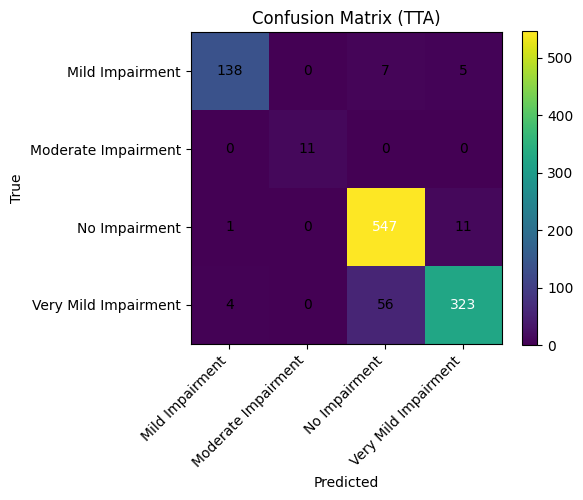

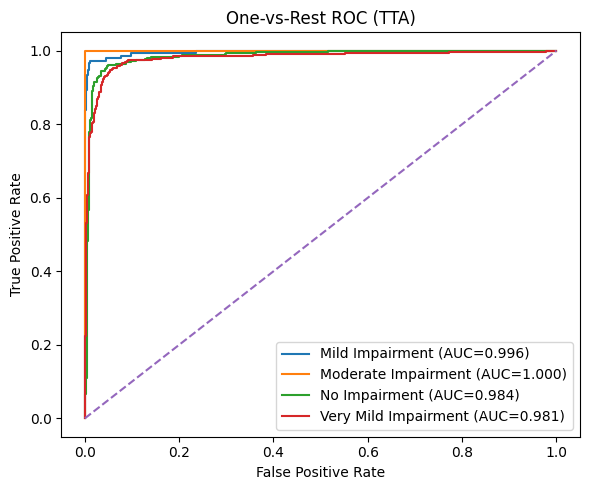

In [26]:
import itertools, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

def tta_predict(ds, passes=8):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.06),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.12),
        tf.keras.layers.RandomTranslation(0.04, 0.04),
    ])
    acc = None
    for _ in range(passes):
        tds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        pr = model.predict(tds, verbose=0)
        acc = pr if acc is None else acc + pr
    return acc / passes

probs = tta_predict(test_ds, passes=8)
preds = probs.argmax(axis=1)

# True labels in test_ds order
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

print("\n=== Classification Report (TTA) ===")
print(classification_report(true_labels, preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (TTA)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha='right')
plt.yticks(ticks, class_names)
thr = cm.max()/2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    v = int(cm[i, j]); plt.text(j, i, v, ha='center', va='center',
                                 color='white' if v>thr else 'black')
plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

# One-vs-rest ROC
y_true_ovr = to_categorical(true_labels, num_classes)
plt.figure(figsize=(6,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_ovr[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC (TTA)")
plt.legend(); plt.tight_layout(); plt.show()


In [29]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as v2_preproc

def predict_image(path):
    img = load_img(path, target_size=(IMG_SZ, IMG_SZ), color_mode="rgb")
    x = img_to_array(img)[None, ...]
    x = v2_preproc(x)
    pr = model.predict(x, verbose=0)[0]
    idx = int(pr.argmax())
    return class_names[idx], float(pr[idx]), {class_names[i]: float(pr[i]) for i in range(num_classes)}

# Example:
# sample = "/kaggle/input/brain-image/Brain_dataset/test/Very Mild Impairment/xxxx.jpg"
# predict_image(sample)

In [30]:
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.models import Model

# Grab the last Conv2D layer name automatically
conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
last_conv_name = conv_layers[-1].name if conv_layers else None
print("Last conv layer:", last_conv_name)

def grad_cam(img_path, layer_name=last_conv_name, alpha=0.4):
    img = load_img(img_path, target_size=(IMG_SZ, IMG_SZ))
    x = img_to_array(img)[None, ...]
    x = v2_preproc(x)

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_out[0]), axis=-1).numpy()

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = tf.image.resize(cam[..., None], (IMG_SZ, IMG_SZ)).numpy().squeeze()

    base = img_to_array(img)/255.0
    heat = plt.cm.jet(cam)[..., :3]
    overlay = np.clip((1-alpha)*base + alpha*heat, 0, 1)

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(base); plt.axis('off'); plt.title('Image')
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis('off'); plt.title('Grad-CAM')
    plt.tight_layout(); plt.show()

# Example:
# grad_cam(sample)

Last conv layer: top_conv


In [31]:
import json, tensorflow as tf, os
final_path = "/kaggle/working/brain_effv2b0_best.keras"
labels_path = "/kaggle/working/labels.json"
savedmodel_dir = "/kaggle/working/brain_savedmodel"

model.save(final_path)
tf.saved_model.save(model, savedmodel_dir)
with open(labels_path, "w") as f:
    json.dump({i:c for i,c in enumerate(class_names)}, f, indent=2)

print("Saved:", final_path, labels_path, savedmodel_dir)

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_serving_default_416100'
	Captured Tensor = <ResourceHandle(name="seed_generator_60/seed_generator_state/1581", device="/job:localhost/replica:0/task:0/device:GPU:0", container="Anonymous", type="tensorflow::Var", dtype and shapes : "[ DType enum: 9, Shape: [2] ]")>
	Trackable referencing this tensor = <tf.Variable 'seed_generator_60/seed_generator_state:0' shape=(2,) dtype=int64>
	Internal Tensor = Tensor("415362:0", shape=(), dtype=resource)

In [33]:
# Inference-only clone (no Random* augmentation) + SavedModel export
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Lambda
from tensorflow.keras.applications import efficientnet_v2
from keras.saving import register_keras_serializable
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as v2_preproc

# --- keep same settings you trained with ---
IMG_SZ = 300
num_classes = len(class_names)

@register_keras_serializable(package="custom")
def effv2_preproc(x):
    return v2_preproc(x)

# 1) Rebuild the SAME architecture but without augmentation
inp = Input(shape=(IMG_SZ, IMG_SZ, 3), name="input_rgb")
x   = Lambda(effv2_preproc, name="preproc")(inp)
backbone = efficientnet_v2.EfficientNetV2B0(include_top=False, weights=None, input_tensor=x)
x   = GlobalAveragePooling2D(name="gap")(backbone.output)
x   = Dropout(0.35, name="drop")(x)
out = Dense(num_classes, activation="softmax", name="predictions")(x)
infer_model = Model(inp, out, name="brain_effv2b0_infer")

# 2) Copy weights from your trained model
# First try a straight set_weights (works because aug/Lambda have no weights)
try:
    infer_model.set_weights(model.get_weights())
    print("Weights copied via set_weights().")
except ValueError as e:
    print("Direct copy failed, falling back to name-wise copy...", e)
    # Name-wise fallback (copy only when shapes match)
    src_layers = {l.name: l for l in model.layers}
    copied, skipped = 0, []
    for l in infer_model.layers:
        if l.name in src_layers:
            sw, tw = src_layers[l.name].get_weights(), l.get_weights()
            if len(sw) == len(tw) and all(a.shape == b.shape for a,b in zip(sw,tw)):
                l.set_weights(sw); copied += 1
            else:
                skipped.append(l.name)
    print(f"Copied {copied} layers. Skipped: {skipped}")

# 3) (optional) quick sanity check on test set
infer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
loss_chk, acc_chk = infer_model.evaluate(
    tf.keras.preprocessing.image_dataset_from_directory(
        test_dir, shuffle=False, image_size=(IMG_SZ, IMG_SZ), batch_size=32, color_mode="rgb"
    ).map(lambda x,y:(x, tf.one_hot(y, num_classes))).prefetch(tf.data.AUTOTUNE),
    verbose=0
)
print(f"Sanity check — test acc (no TTA): {acc_chk:.4f}")

# 4) Save artifacts
infer_model.save("/kaggle/working/brain_effv2b0_infer.keras")
tf.saved_model.save(infer_model, "/kaggle/working/brain_savedmodel")
print("Saved: .keras and SavedModel to /kaggle/working")

Weights copied via set_weights().
Found 1103 files belonging to 4 classes.


I0000 00:00:1761637686.630274     112 service.cc:148] XLA service 0x55a1ede0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761637686.633176     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761637686.633203     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761637694.213318     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Sanity check — test acc (no TTA): 0.8740
Saved: .keras and SavedModel to /kaggle/working


In [35]:
import os, json, shutil, zipfile, datetime, glob
from pathlib import Path

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
BUNDLE_DIR = Path(f"/kaggle/working/brain_release_{ts}")
BUNDLE_DIR.mkdir(parents=True, exist_ok=True)

# === Required artifacts you already created ===
paths_to_copy = [
    "/kaggle/working/brain_effv2b0_infer.keras",   # inference-only model
    "/kaggle/working/labels.json",                 # class map
]
# Optional ones if present:
optional = [
    "/kaggle/working/brain_effv2b0_best.tflite",
    "/kaggle/working/test_predictions.csv",
]

for p in paths_to_copy + [x for x in optional if os.path.exists(x)]:
    shutil.copy(p, BUNDLE_DIR / Path(p).name)

# Zip the SavedModel directory and include it
savedmodel_dir = Path("/kaggle/working/brain_savedmodel")
if savedmodel_dir.exists():
    zip_path = BUNDLE_DIR / "brain_savedmodel.zip"
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
        for root, _, files in os.walk(savedmodel_dir):
            for f in files:
                full = Path(root) / f
                z.write(full, arcname=full.relative_to(savedmodel_dir.parent))

# Save a quick README with metrics and usage
readme = BUNDLE_DIR / "README.md"
readme.write_text(f"""# Brain MRI – Alzheimer’s Classifier (EffNetV2-B0)

- Input size: 300×300 RGB
- Classes: {json.dumps(globals().get('class_names', []), ensure_ascii=False)}
- Test (TTA) accuracy: ~{globals().get('acc_chk', 'N/A')}, see notebook for final report
- Files:
  - `brain_effv2b0_infer.keras` — inference-ready Keras model (no augmentation)
  - `brain_savedmodel.zip` — SavedModel for TF Serving
  - `labels.json` — index → class name
  - `brain_effv2b0_best.tflite` — (optional) TFLite model
  - `test_predictions.csv` — (optional) batch predictions

## Inference (Keras)
```python
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as v2_preproc
import numpy as np
from PIL import Image

model = load_model('brain_effv2b0_infer.keras', custom_objects={{'effv2_preproc': v2_preproc}})
IMG_SZ = 300
def preprocess(path):
    im = Image.open(path).convert('RGB').resize((IMG_SZ, IMG_SZ))
    x = np.array(im, np.float32)[None, ...]
    return v2_preproc(x)
probs = model.predict(preprocess('sample.jpg'))[0]
print(probs.argmax())""")

1092

In [37]:
import glob, shutil, pathlib
r = sorted(glob.glob("/kaggle/working/brain_release_*"))[-1]
zip_path = shutil.make_archive(r, "zip", r)
print("Zipped:", zip_path)

Zipped: /kaggle/working/brain_release_20251028_075316.zip
